In [30]:
%pip install --upgrade pip
%pip install autogluon

from autogluon.tabular import TabularDataset, TabularPredictor

Note: you may need to restart the kernel to use updated packages.
  Using cached autogluon-1.1.1-py3-none-any.whl.metadata (11 kB)
  Using cached autogluon.multimodal-1.1.1-py3-none-any.whl.metadata (12 kB)
  Using cached autogluon.timeseries-1.1.1-py3-none-any.whl.metadata (12 kB)
  Using cached ray-2.10.0-cp39-cp39-win_amd64.whl.metadata (13 kB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached pillow-10.4.0-cp39-cp39-win_amd64.whl.metadata (9.3 kB)
  Using cached torch-2.3.1-cp39-cp39-win_amd64.whl.metadata (26 kB)
  Using cached lightning-2.3.3-py3-none-any.whl.metadata (35 kB)
  Using cached transformers-4.40.2-py3-none-any.whl.metadata (137 kB)
  Using cached accelerate-0.21.0-py3-none-any.whl.metadata (17 kB)
  Using cached jsonschema-4.21.1-py3-none-any.whl.metadata (7.8 kB)
  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to 

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      <string>:32: DeprecationWarning: Use shutil.which instead of find_executable
      <string>:33: DeprecationWarning: Use shutil.which instead of find_executable
      fatal: not a git repository (or any of the parent directories): .git
      Traceback (most recent call last):
        File "c:\Users\kaili\AppData\Local\Programs\Python\Python39\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\kaili\AppData\Local\Programs\Python\Python39\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "c:\Users\kaili\AppData\Local\Programs\Python\Python39\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_

In [31]:
import pandas as pd
import numpy as np
from datetime import datetime

In [32]:
sensing_data = pd.read_csv('../../Dataset/Sensing/sensingdata.csv')
demographics_data = pd.read_csv('../../Dataset/Demographics/demographics.csv')

In [33]:
# Merge sensing and demographics data
df = sensing_data.merge(
    demographics_data,
    on='uid',  # common column between both datasets
    how='inner'  # only keep rows that exist in both datasets
)

In [34]:
import pandas as pd
import numpy as np
from datetime import datetime

In [35]:
# Merge sensing and demographics data
df = sensing_data.merge(
    demographics_data,
    on='uid',  # common column between both datasets
    how='inner'  # only keep rows that exist in both datasets
)

In [36]:
# Now you can check the shape of your merged dataset
print("Original sensing data shape:", sensing_data.shape)
print("Demographics data shape:", demographics_data.shape)
print("Merged data shape:", df.shape)

print("\nMerged columns:", df.columns.tolist())


Original sensing data shape: (216065, 651)
Demographics data shape: (216, 3)
Merged data shape: (214759, 653)

Merged columns: ['uid', 'is_ios', 'day', 'act_in_vehicle_ep_0', 'act_in_vehicle_ep_1', 'act_in_vehicle_ep_2', 'act_in_vehicle_ep_3', 'act_in_vehicle_hr_0', 'act_in_vehicle_hr_1', 'act_in_vehicle_hr_10', 'act_in_vehicle_hr_11', 'act_in_vehicle_hr_12', 'act_in_vehicle_hr_13', 'act_in_vehicle_hr_14', 'act_in_vehicle_hr_15', 'act_in_vehicle_hr_16', 'act_in_vehicle_hr_17', 'act_in_vehicle_hr_18', 'act_in_vehicle_hr_19', 'act_in_vehicle_hr_2', 'act_in_vehicle_hr_20', 'act_in_vehicle_hr_21', 'act_in_vehicle_hr_22', 'act_in_vehicle_hr_23', 'act_in_vehicle_hr_3', 'act_in_vehicle_hr_4', 'act_in_vehicle_hr_5', 'act_in_vehicle_hr_6', 'act_in_vehicle_hr_7', 'act_in_vehicle_hr_8', 'act_in_vehicle_hr_9', 'act_on_bike_ep_0', 'act_on_bike_ep_1', 'act_on_bike_ep_2', 'act_on_bike_ep_3', 'act_on_bike_hr_0', 'act_on_bike_hr_1', 'act_on_bike_hr_10', 'act_on_bike_hr_11', 'act_on_bike_hr_12', 'act_on

In [37]:
# Create quarter-based split function
def create_quarter_based_split(df, test_size=0.2, random_state=42):
    # Convert YYYYMMDD to datetime
    df['date'] = pd.to_datetime(df['day'], format='%Y%m%d')
    
    # Extract quarter information
    df['quarter'] = df['date'].dt.quarter
    
    # Get unique quarters in the dataset
    unique_quarters = df['quarter'].unique()
    
    # Randomly select quarters for test set
    np.random.seed(random_state)
    num_test_quarters = max(1, int(len(unique_quarters) * test_size))
    test_quarters = np.random.choice(unique_quarters, size=num_test_quarters, replace=False)
    
    # Split data into train and test
    test_data = df[df['quarter'].isin(test_quarters)].copy()
    train_data = df[~df['quarter'].isin(test_quarters)].copy()
    
    # Drop temporary columns
    train_data = train_data.drop(['date', 'quarter'], axis=1)
    test_data = test_data.drop(['date', 'quarter'], axis=1)
    
    return train_data, test_data

In [38]:
# Convert to TabularDataset and split
df = TabularDataset(df)
train_data, test_data = create_quarter_based_split(df)


In [41]:
# subsample
subsample_size = 200
train_data = train_data.sample(n=subsample_size, random_state=0)

# Define your label column
#currently in seconds, the duration of a full day
label = 'unlock_duration_ep_0'  # Replace with your actual target column name

In [42]:
# Train the model
predictor = TabularPredictor(
    label=label,
    eval_metric='rmse'  # Root Mean Square Error for regression
).fit(
    train_data,
    time_limit=600,  # 10 minutes
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels\ag-20241120_081852"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       2.38 GB / 7.92 GB (30.1%)
Disk Space Avail:   13.16 GB / 237.23 GB (5.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout va

In [43]:
#eval model performance
test_performance = predictor.evaluate(test_data)
print(test_performance)

{'root_mean_squared_error': -2095.0107857795956, 'mean_squared_error': -4389070.192532838, 'mean_absolute_error': -1061.8685555173677, 'r2': 0.9101445447126033, 'pearsonr': 0.9545979707414027, 'median_absolute_error': -621.1734941406248}


In [44]:
#generate for new data
predictions = predictor.predict(test_data)
print(predictions.head())

24    8013.505371
25    3267.222656
26    4668.145996
27    6580.099609
28    4941.981934
Name: unlock_duration_ep_0, dtype: float32


In [47]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


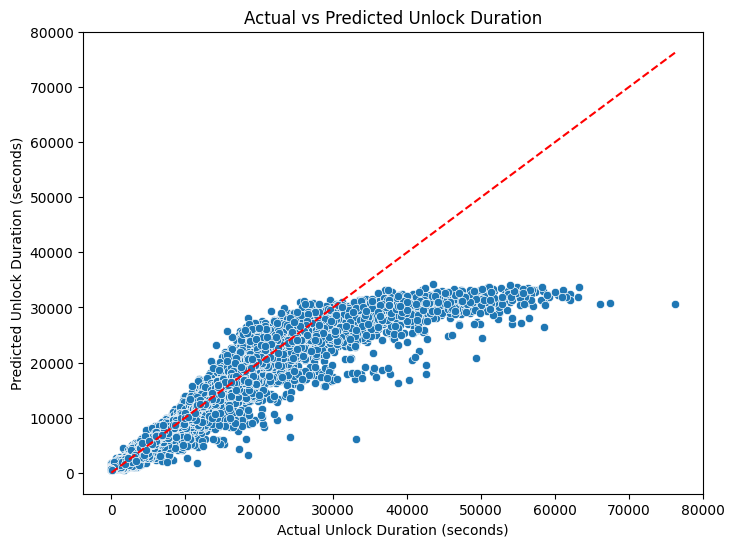

In [58]:
# Assuming 'predicted_unlock_duration' is the column storing the model's predictions
test_data['predicted_unlock_duration'] = predictor.predict(test_data)

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=test_data['unlock_duration_ep_0'], y=test_data['predicted_unlock_duration'])
plt.title("Actual vs Predicted Unlock Duration")
plt.xlabel("Actual Unlock Duration (seconds)")
plt.ylabel("Predicted Unlock Duration (seconds)")
plt.plot([test_data['unlock_duration_ep_0'].min(), test_data['unlock_duration_ep_0'].max()], 
         [test_data['unlock_duration_ep_0'].min(), test_data['unlock_duration_ep_0'].max()], 
         color="red", linestyle="--")  # Diagonal reference line
plt.show()

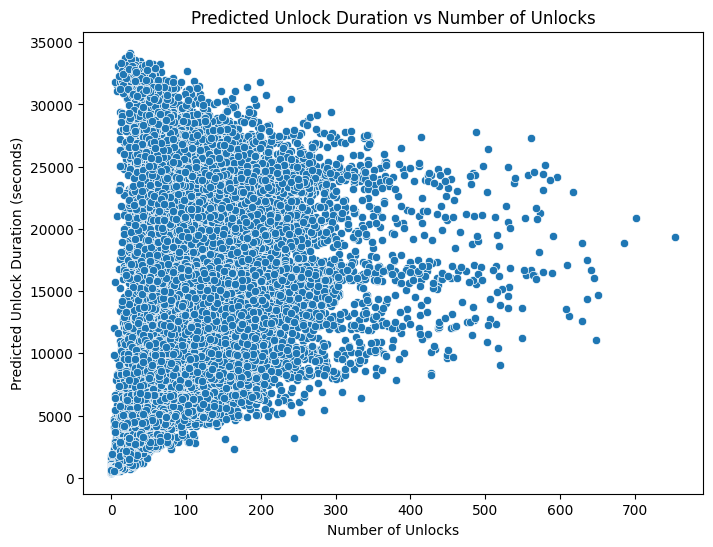

In [61]:
# Scatter plot of predicted unlock duration vs number of unlocks
#when number of unlocks is higher, the predicted unlock duration decrease/moves towards
#the middle
plt.figure(figsize=(8, 6))
sns.scatterplot(data=test_data, x='unlock_num_ep_0', y='predicted_unlock_duration')
plt.title("Predicted Unlock Duration vs Number of Unlocks")
plt.xlabel("Number of Unlocks")
plt.ylabel("Predicted Unlock Duration (seconds)")
plt.show()